#### Download gdown, segmentation_models_pytorch and torchsummary if needed

In [83]:
!pip install gdown segmentation_models_pytorch==0.1.3 torchsummary

## Import Packages

In [94]:
%matplotlib inline

import cv2
import gdown
import matplotlib.pyplot as plt
import os
import torch
import segmentation_models_pytorch as smp

from PIL import Image
from torch.utils.data import Dataset
from torchsummary import summary
from utils_cs import predict_image_mask_miou

## Check Train Image

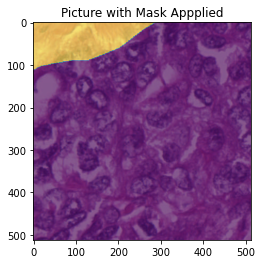

In [85]:
IMAGE_PATH = "./data/test/images/TCGA-A2-A04T-DX1_xmin72145_ymin39078_MPP-0.2300_51.png"
MASK_PATH = "./data/test/masks/TCGA-A2-A04T-DX1_xmin72145_ymin39078_MPP-0.2300_51.png"

img = Image.open(IMAGE_PATH)
mask = Image.open(MASK_PATH)

plt.imshow(img)
plt.imshow(mask, alpha=0.6)
plt.title('Picture with Mask Appplied')
plt.show()

## Load Test Dataset

In [86]:
class CrowdsourcingTestDataset(Dataset):
    def __init__(self, img_path, mask_path, X):
        self.img_path = img_path
        self.mask_path = mask_path
        self.X = X

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        img = cv2.imread(self.img_path + self.X[idx])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.mask_path + self.X[idx], 0)
        img = Image.fromarray(img)
        mask = torch.from_numpy(mask).long()  # to tensor
        return img, mask

In [88]:
TEST_IMAGE_PATH = "data/test/images/"
TEST_MASK_PATH = "data/test/masks/"
X_test = os.listdir(TEST_IMAGE_PATH)

test_set = CrowdsourcingTestDataset(TEST_IMAGE_PATH, TEST_MASK_PATH, X_test)

## Download Model from GDrive

URL:
* Unet-MobileNet (15 epochs): https://drive.google.com/uc?id=1xxSwpUMfoOGzeSDaszzgw1utdgsMjt1v&export=download
* Unet (16 epochs): https://drive.google.com/uc?id=1-cmFD1_GLMgXW8ssJ_555qowG0IxUKyU&export=download

In [28]:
# Copy the link here
url = "https://drive.google.com/uc?id=1xxSwpUMfoOGzeSDaszzgw1utdgsMjt1v&export=download"
gdown.download(url, quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1xxSwpUMfoOGzeSDaszzgw1utdgsMjt1v&export=download
To: /home/ec2-user/SageMaker/project/Unet-Mobilenet.pt
26.8MB [00:00, 34.8MB/s]


'Unet-Mobilenet.pt'

## Load Model

In [89]:
MODEL_PATH = "Unet-Mobilenet.pt"

In [ ]:
""" Full assembly of the parts to form the complete network """

import torch
import torch.nn as nn
import torch.nn.functional as F


class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)


class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)


class Up(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels , in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)


    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        # if you have padding issues, see
        # https://github.com/HaiyongJiang/U-Net-Pytorch-Unstructured-Buggy/commit/0e854509c2cea854e247a9c615f175f76fbb2e3a
        # https://github.com/xiaopeng-liao/Pytorch-UNet/commit/8ebac70e633bac59fc22bb5195e513d5832fb3bd
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)


class UNet(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=True):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        factor = 2 if bilinear else 1
        self.down4 = Down(512, 1024 // factor)
        self.up1 = Up(1024, 512 // factor, bilinear)
        self.up2 = Up(512, 256 // factor, bilinear)
        self.up3 = Up(256, 128 // factor, bilinear)
        self.up4 = Up(128, 64, bilinear)
        self.outc = OutConv(64, n_classes)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits

In [10]:
# 1. You need to load the model architecture to test UNet from https://github.com/milesial/Pytorch-UNet
# from unet import UNet

model = UNet(n_channels=3, n_classes=22).to(device)
model = torch.load(MODEL_PATH)

In [90]:
# 2. UNet-Mobilenet 
model = smp.Unet('mobilenet_v2', encoder_weights='imagenet', 
                 classes=22, 
                 activation=None, 
                 encoder_depth=5, 
                 decoder_channels=[256, 128, 64, 32, 16])
model = torch.load(MODEL_PATH)
mean=[0.5, 0.5, 0.5]
std=[0.5, 0.5, 0.5]

In [100]:
#summary(model, (3, 512, 512)) # train and test image size = (3, 512, 512)

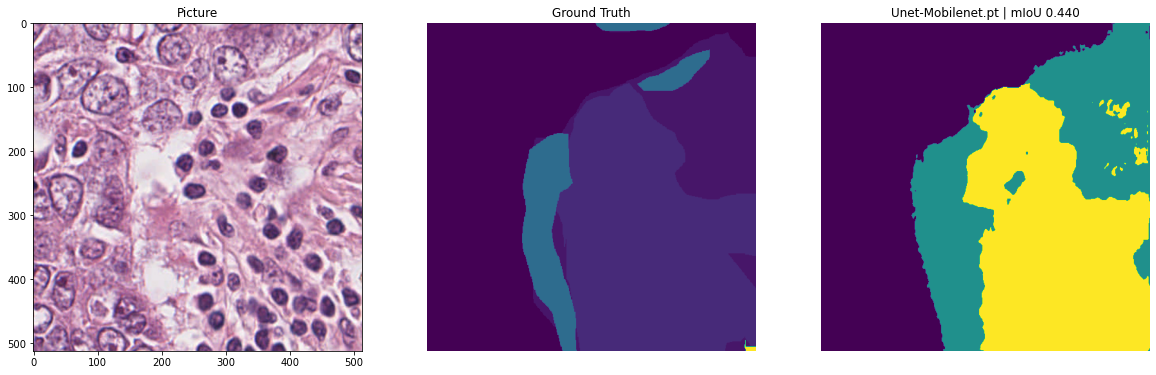

In [101]:
model.eval()
image, mask = test_set[390]
# score = (iou_score, dice_score)
pred_mask, score = predict_image_mask_miou(model, image, mask, mean=mean, std=std)

fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(20,10))
ax1.imshow(image)
ax1.set_title("Picture");

ax2.imshow(mask)
ax2.set_title("Ground Truth")
ax2.set_axis_off()

ax3.imshow(pred_mask)
ax3.set_title("{} | mIoU {:.3f}".format(MODEL_PATH, score[0]))
ax3.set_axis_off()